# **Assignment 6**
## **Group 3:**
* Karyl Grasparil
* Mariah Quinquito
* Yanna Polonia

In [1]:
from autocorrect import Speller
from nltk import tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics import accuracy_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, SpatialDropout1D, Dropout, GRU, LSTM, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import nltk
import numpy as np
import re
import seaborn as sns
import textwrap

2024-11-25 11:30:09.944670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Data

## Loading the three fatafiles into training, validation and testing dataframes

In [2]:
train_data = pd.read_csv('archive-2/emotion-labels-train.csv')
train_data.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


In [3]:
test_data = pd.read_csv('archive-2/emotion-labels-test.csv')
test_data.head()

,text,label
0,You must be knowing #blithe means (adj.) Happ...,joy
1,Old saying 'A #smile shared is one gained for ...,joy
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...,joy
3,@Elaminova sparkling water makes your life spa...,joy
4,I'm tired of everybody telling me to chill out...,joy


In [4]:
val_data = pd.read_csv('archive-2/emotion-labels-val.csv')
val_data.head()

,text,label
0,"@theclobra lol I thought maybe, couldn't decid...",joy
1,Nawaz Sharif is getting more funnier than @kap...,joy
2,Nawaz Sharif is getting more funnier than @kap...,joy
3,@tomderivan73 😁...I'll just people watch and e...,joy
4,I love my family so much #lucky #grateful #sma...,joy


## Verifying datatypes and if there are any missing values

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613 entries, 0 to 3612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3613 non-null   object
 1   label   3613 non-null   object
dtypes: object(2)
memory usage: 56.6+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3142 non-null   object
 1   label   3142 non-null   object
dtypes: object(2)
memory usage: 49.2+ KB


In [7]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    347 non-null    object
 1   label   347 non-null    object
dtypes: object(2)
memory usage: 5.5+ KB


## <span style='color:blue'>Apparently there aren't any missing values and the datatype for each column/feature is the appropiate one.</span>

## Validating for duplicate entries

In [8]:
# Using pandas.DataFrame.duplicates to check for duplicate entries.
train_duplicates = train_data.duplicated()

# Printing duplicate entries count
print(f'Train duplicate entries count: {train_duplicates.sum()}\n')

# Printing duplicates entries
print('Train duplicate entries:\n')
train_data[train_duplicates]

Train duplicate entries count: 0

Train duplicate entries:



,text,label


In [9]:
# Using pandas.DataFrame.duplicates to check for duplicate entries.
test_duplicates = test_data.duplicated()

# Printing duplicate entries count
print(f'Test duplicate entries count: {test_duplicates.sum()}\n')

# Printing duplicates entries
print('Train duplicate entries:\n')
test_data[test_duplicates]

Test duplicate entries count: 0

Train duplicate entries:



,text,label


In [10]:
# Using pandas.DataFrame.duplicates to check for duplicate entries.
val_duplicates = val_data.duplicated()

# Printing duplicate entries count
print(f'Validation duplicate entries count: {val_duplicates.sum()}\n')

# Printing duplicates entries
print('Validation duplicate entries:\n')
val_data[val_duplicates]

Validation duplicate entries count: 0

Validation duplicate entries:



,text,label


## <span style='color:blue'>Based on results previously displayed, there aren't any duplicate entries within the given datasets</span>

## Separating text from labels

In [11]:
train_labels = train_data
train_text = train_data
train_labels = train_labels.drop(['text'], axis = 1)
train_text = train_text.drop(['label'], axis = 1)
train_labels.head()

,label
0,joy
1,joy
2,joy
3,joy
4,joy


In [12]:
train_text.head()

,text
0,Just got back from seeing @GaryDelaney in Burs...
1,Oh dear an evening of absolute hilarity I don'...
2,Been waiting all week for this game ❤️❤️❤️ #ch...
3,"@gardiner_love : Thank you so much, Gloria! Yo..."
4,I feel so blessed to work with the family that...


In [13]:
test_labels = test_data
test_text = test_data
test_labels = test_labels.drop(['text'], axis = 1)
test_text = test_text.drop(['label'], axis = 1)
test_labels.head()

,label
0,joy
1,joy
2,joy
3,joy
4,joy


In [14]:
test_text.head()

,text
0,You must be knowing #blithe means (adj.) Happ...
1,Old saying 'A #smile shared is one gained for ...
2,Bridget Jones' Baby was bloody hilarious 😅 #Br...
3,@Elaminova sparkling water makes your life spa...
4,I'm tired of everybody telling me to chill out...


In [15]:
val_labels = val_data
val_text = val_data
val_labels = val_labels.drop(['text'], axis = 1)
val_text = val_text.drop(['label'], axis = 1)
val_labels.head()

,label
0,joy
1,joy
2,joy
3,joy
4,joy


In [16]:
val_text.head()

,text
0,"@theclobra lol I thought maybe, couldn't decid..."
1,Nawaz Sharif is getting more funnier than @kap...
2,Nawaz Sharif is getting more funnier than @kap...
3,@tomderivan73 😁...I'll just people watch and e...
4,I love my family so much #lucky #grateful #sma...


## Converting the string labels into integers using sklearn.preprocessing.LabelEncoder and displaying which number has been assigned to each label

In [17]:
# Initializing LabelEncoder for the training set
train_encoder = LabelEncoder()

# Fitting and transforming train_labels
train_labels['encoded_label'] = train_encoder.fit_transform(train_labels['label'])
train_labels

,label,encoded_label
0,joy,2
1,joy,2
2,joy,2
3,joy,2
4,joy,2
...,...,...
3608,sadness,3
3609,sadness,3
3610,sadness,3
3611,sadness,3


In [18]:
# Label mapping displaying the encoded label for each label in the training set
label_mapping = dict(zip(train_encoder.classes_, train_encoder.transform(train_encoder.classes_)))
print(label_mapping)

{'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3}


In [19]:
# Initializing LabelEncoder for the testing set
test_encoder = LabelEncoder()

# Fitting and transforming test_labels
test_labels['encoded_label'] = test_encoder.fit_transform(test_labels['label'])
test_labels

,label,encoded_label
0,joy,2
1,joy,2
2,joy,2
3,joy,2
4,joy,2
...,...,...
3137,sadness,3
3138,sadness,3
3139,sadness,3
3140,sadness,3


In [20]:
# Label mapping displaying the encoded label for each label in the testing set
print(dict(zip(test_encoder.classes_, test_encoder.transform(test_encoder.classes_))))

{'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3}


In [21]:
# Initializing LabelEncoder for the validation set
val_encoder = LabelEncoder()

# Fitting and transforming val_labels
val_labels['encoded_label'] = val_encoder.fit_transform(val_labels['label'])
val_labels

,label,encoded_label
0,joy,2
1,joy,2
2,joy,2
3,joy,2
4,joy,2
...,...,...
342,sadness,3
343,sadness,3
344,sadness,3
345,sadness,3


In [22]:
# Label mapping displaying the encoded label for each label in the validation set
print(dict(zip(val_encoder.classes_, val_encoder.transform(val_encoder.classes_))))

{'anger': 0, 'fear': 1, 'joy': 2, 'sadness': 3}


## Reshaping the labels datasets into a 2d array 

In [23]:
# Getting rid of the label column in train_labels
train_encoded_labels = train_labels.drop(columns = ['label'])

# Converting into a 2d numpy array 
train_encoded_labels = train_encoded_labels.to_numpy()
train_encoded_labels.shape

(3613, 1)

In [24]:
# Getting rid of the label column in test_labels
test_encoded_labels = test_labels.drop(columns = ['label'])

# Converting into a 2d numpy array 
test_encoded_labels = test_encoded_labels.to_numpy()
test_encoded_labels.shape

(3142, 1)

In [25]:
# Getting rid of the label column in val_labels
val_encoded_labels = val_labels.drop(columns = ['label'])

# Converting into a 2d numpy array 
val_encoded_labels = val_encoded_labels.to_numpy()
val_encoded_labels.shape

(347, 1)

## Creating a bar plot using seaborn.barplot of the number of elements in each category over the entire dataset

In [26]:
# Combining train, test and validation labels into a DatyaFrame named labels
labels = pd.concat([train_labels, test_labels, val_labels], ignore_index = True)

# Dropping the encoded_label column
labels = labels.drop('encoded_label', axis = 1)
labels

,label
0,joy
1,joy
2,joy
3,joy
4,joy
...,...
7097,sadness
7098,sadness
7099,sadness
7100,sadness


In [27]:
# Getting the count per each label
label_count = labels.groupby('label').size().reset_index(name = 'count')
label_count

,label,count
0,anger,1701
1,fear,2252
2,joy,1616
3,sadness,1533


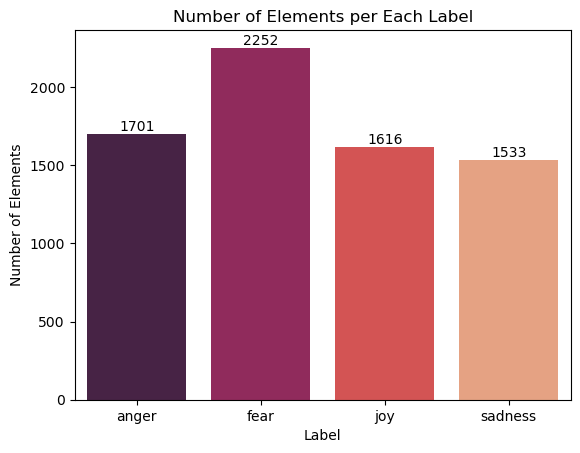

In [28]:
plot = sns.barplot(data = label_count, x = 'label', y = 'count', hue = 'label', palette = 'rocket')

# Adding counts on each bar
for p in plot.patches:
    width = p.get_width()
    x = p.get_x() + width / 2
    y = p.get_height()
    plot.text(x, y, f'{y:.0f}', ha = 'center', va = 'bottom')

plt.xlabel('Label')
plt.ylabel('Number of Elements')
plt.title('Number of Elements per Each Label')
plt.show()

## <span style='color:blue'>The dataset exhibits some degree of imbalance between the labels, although this is not a major concern. The 'fear' label has a slightly higher representation (2,252) compared to the other labels, which are almost balanced. As a result, there may be a slight bias toward the 'fear' label, but the overall distribution is not severely skewed. Therefore, significant issues with model performance due to class imbalance are not expected.</span>

## Performing the following steps on the tweets in the prefer order to do:
* ### Tokenize each tweet into words.
* ### Speller use from the autocorrect library to correct spelling mistakes (in case it might be useful).
* ### Create a list of stopwords and removing these.
* ### Usage of PorterStemmer or WordNetLemmatizer from nltk.stem on the text.
* ### Usage of regular expressions to do any additional cleanup of the text.

In [29]:
# Converting train_text into a list
train_raw_text = train_text['text'].to_list()
len(train_raw_text)

3613

In [30]:
# Converting test_text into a list
test_raw_text = test_text['text'].to_list()
len(test_raw_text)

3142

In [31]:
# Converting val_text into a list
val_raw_text = val_text['text'].to_list()
len(val_raw_text)

347

In [32]:
# Initializing the speller using English as the language
speller = Speller(lang = 'en')

In [33]:
# Printing a random tweet
sample_1 = train_raw_text[1]
sample_1

"Oh dear an evening of absolute hilarity I don't think I have laughed so much in a long time! 😂"

In [34]:
# Applying speller to sample_1
sample_corrected_1 = speller(sample_1)
sample_corrected_1

"Oh dear an evening of absolute clarity I don't think I have laughed so much in a long time! 😂"

In [35]:
# Printing a random tweet
sample_2 = train_raw_text[2505]
sample_2

'The best #revenge is to move on, get over it, and continue to #succeed. Never give someone the #satisfaction of watching you #suffer....!!!'

In [36]:
# Applying speller to sample_2
sample_corrected_2 = speller(sample_2)
sample_corrected_2

'The best #revenge is to move on, get over it, and continue to #succeed. Never give someone the #satisfaction of watching you #suffer....!!!'

In [37]:
# Printing a random tweet
sample_3 = train_raw_text[3602]
sample_3

'Never dull moment here'

In [38]:
# Applying speller to sample_3
sample_corrected_3 = speller(sample_3)
sample_corrected_3

'Never dull moment here'

## <span style='color:blue'>After exploring a few random tweets, it became apparent that in about two-thirds of the samples, no modifications were made after appying the Speller function. In cases where the tweet was modified, the term replacement altered the meaning of the tweet, which was unnecessary for this task. Therefore, we have decided not to use a spell checker, as it would only add unnecessary complexity to the preprocessing stage and slow down the process. This decision will help streamline the overall workflow.</span>

In [39]:
# Using stop words from https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt, which are three or more characters
en_stop_words = set(["'ll", "'tis", "'twas", "'ve", "a's", "able", "ableabout", "about", "above", "abroad", "abst", \
                   "accordance", "according","accordingly", "across", "act", "actually", "added", "adj", \
                   "adopted", "affected", "affecting", "affects", "after", "afterwards", "again", "against", \
                   "ago", "ahead", "ain't", "aint", "all", "allow", "allows", "almost", "alone", "along", \
                   "alongside", "already", "also", "although", "always", "amid", "amidst", "among", "amongst", \
                   "amoungst", "amount", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", \
                   "anyone", "anything", "anyway", "anyways", "anywhere", "apart", "apparently", "appear", \
                   "appreciate", "appropriate", "approximately", "are", "area", "areas", "aren", "aren't", \
                   "arent", "arise", "around", "arpa", "aside", "ask", "asked", "asking", "asks", "associated", \
                   "at", "au", "auth", "available", "aw", "away", "awfully", "az", "b", "ba", "back", "backed", \
                   "as", "backing", "backs", "backward", "backwards", "became", "because", "become", "becomes", \
                   "becoming", "been", "before", "beforehand", "began", "begin", "beginning", "beginnings", \
                   "begins", "behind", "being", "beings", "believe", "below", "beside", "besides", "best", \
                   "better", "between", "beyond", "big", "bill", "billion", "biol", "both", "bottom", "brief", \
                   "briefly", "but", "buy", "c'mon", "c's", "call", "came", "can", "can't", "cannot", "cant", \
                   "caption", "case", "cases", "cause", "causes", "certain", "certainly", "changes", "clear", \
                   "clearly", "click", "cmon", "co.", "com", "come", "comes", "computer", "con", "concerning", \
                   "consequently", "consider", "considering", "contain", "containing", "contains", "copy", \
                   "corresponding", "could", "could've", "couldn", "couldn't", "couldnt", "course", "cry", \
                   "currently", "dare", "daren't", "darent", "date", "dear", "definitely", "describe", "described", \
                   "despite", "detail", "did", "didn", "didn't", "didnt", "differ", "different", "differently", \
                   "directly", "does", "doesn", "doesn't", "doesnt", "doing", "don", "don't", "done", "dont", \
                   "doubtful", "down", "downed", "downing", "downs", "downwards", "due", "during", "each", \
                   "early", "edu", "effect", "eight", "eighty", "either", "eleven", "else", "elsewhere", "empty", \
                   "end", "ended", "ending", "ends", "enough", "entirely", "especially", "et-al", "etc", "even", \
                   "evenly", "ever", "evermore", "every", "everybody", "everyone", "everything", "everywhere", \
                   "exactly", "example", "except", "face", "faces", "fact", "facts", "fairly", "far", "farther", \
                   "felt", "few", "fewer", "fifteen", "fifth", "fifty", "fify", "fill", "find", "finds", "fire", \
                   "first", "five", "fix", "followed", "following", "follows", "for", "forever", "former", \
                   "formerly", "forth", "forty", "forward", "found", "four", "free", "from", "front", "full", \
                   "fully", "further", "furthered", "furthering", "furthermore", "furthers", "gave", "general", \
                   "generally", "get", "gets", "getting", "give", "given", "gives", "giving", "gmt", "goes", \
                   "going", "gone", "good", "goods", "got", "gotten", "gov", "great", "greater", "greatest", \
                   "greetings", "group", "grouped", "grouping", "groups", "had", "hadn't", "hadnt", "half", \
                   "happens", "hardly", "has", "hasn", "hasn't", "hasnt", "have", "haven", "haven't", "havent", \
                   "having", "he'd", "he'll", "he's", "hed", "hell", "hello", "help", "hence", "her", "here", \
                   "here's", "hereafter", "hereby", "herein", "heres", "hereupon", "hers", "herself", "herse”", \
                   "hes", "hid", "high", "higher", "highest", "him", "himself", "himse”", "his", "hither", \
                   "home", "homepage", "hopefully", "how", "how'd", "how'll", "how's", "howbeit", "however", \
                   "htm", "html", "http", "hundred", "i", "i'd", "i'll", "i'm", "i've", "i.e.", "ignored", "ill", \
                   "immediate", "immediately", "importance", "important", "inasmuch", "inc", "inc.", "indeed", \
                   "index", "indicate", "indicated", "indicates", "information", "inner", "inside", "insofar", \
                   "instead", "int", "interest", "interested", "interesting", "interests", "into", "invention", \
                   "inward", "is", "isn", "isn't", "isnt", "it'd", "it'll", "it's", "itd", "itll", "its", \
                   "itself", "itse”", "ive", "join", "just", "keep", "keeps", "kept", "keys", "kind", "knew", \
                   "know", "known", "knows", "large", "largely", "last", "lately", "later", "latest", "latter", \
                   "latterly", "least", "length", "less", "lest", "let", "let's", "lets", "like", "liked", \
                   "likely", "likewise", "line", "little", "long", "longer", "longest", "look", "looking", \
                   "looks", "low", "lower", "ltd", "made", "mainly", "make", "makes", "making", "man", "many", \
                   "may", "maybe", "mayn't", "maynt", "me", "mean", "means", "meantime", "meanwhile", "member", \
                   "members", "men", "merely", "microsoft", "might", "might've", "mightn't", "mightnt", "mil", \
                   "mill", "million", "mine", "minus", "miss", "more", "moreover", "most", "mostly", "move", \
                   "mrs", "msie", "much", "mug", "must", "must've", "mustn't", "mustnt", "my", "myself", "myse”", \
                   "name", "namely", "nay", "near", "nearly", "necessarily", "necessary", "need", "needed", \
                   "needing", "needn't", "neednt", "needs", "neither", "net", "netscape", "never", "neverf", \
                   "neverless", "nevertheless", "new", "newer", "newest", "next", "nine", "ninety", "no-one", \
                   "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", \
                   "nothing", "notwithstanding", "novel", "now", "nowhere", "null", "number", "numbers", \
                   "obtain", "obtained", "obviously", "off", "often", "okay", "old", "older", "oldest", \
                   "omitted", "once", "one", "one's", "ones", "only", "onto", "open", "opened", "opening", \
                   "opens", "opposite", "ord", "order", "ordered", "ordering", "orders", "org", "other", \
                   "others", "otherwise", "ought", "oughtn't", "oughtnt", "our", "ours", "ourselves", "out", \
                   "outside", "over", "overall", "owing", "own", "page", "pages", "part", "parted", "particular", \
                   "particularly", "parting", "parts", "past", "per", "perhaps", "place", "placed", "places", \
                   "please", "plus", "pmid", "point", "pointed", "pointing", "points", "poorly", "possible", \
                   "possibly", "potentially", "predominantly", "present", "presented", "presenting", "presents", \
                   "presumably", "previously", "primarily", "probably", "problem", "problems", "promptly", \
                   "proud", "provided", "provides", "put", "puts", "que", "quickly", "quite", "ran", "rather", \
                   "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", \
                   "regardless", "regards", "related", "relatively", \
                   "research", "reserved", "respectively", "resulted", "resulting", "results", "right", "ring", \
                   "room", "rooms", "round", "run", "said", "same", "saw", "say", "saying", "says", "sec", \
                   "second", "secondly", "seconds", "section", "see", "seeing", "seem", "seemed", "seeming", \
                   "seems", "seen", "sees", "self", "selves", "sensible", "sent", "serious", "seriously", \
                   "seven", "seventy", "several", "shall", "shan't", "shant", "she", "she'd", "she'll", "she's", \
                   "shed", "shell", "shes", "should", "should've", "shouldn", "shouldn't", "shouldnt", "show", \
                   "showed", "showing", "shown", "showns", "shows", "side", "sides", "significant", \
                   "significantly", "similar", "similarly", "since", "sincere", "site", "six", "sixty", \
                   "slightly", "small", "smaller", "smallest", "some", "somebody", "someday", "somehow", \
                   "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", \
                   "soon", "sorry", "specifically", "specified", "specify", "specifying", "state", "states", \
                   "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", \
                   "suggest", "sup", "sure", "system", "t's", "take", "taken", "taking", "tell", "ten", "tends", \
                   "test", "text", "than", "thank", "thanks", "thanx", "that", "that'll", "that's", "that've", \
                   "thatll", "thats", "thatve", "the", "their", "theirs", "them", "themselves", "then", \
                   "thence", "there", "there'd", "there'll", "there're", "there's", "there've", "thereafter", \
                   "thereby", "thered", "therefore", "therein", "therell", "thereof", "therere", "theres", \
                   "thereto", "thereupon", "thereve", "these", "they", "they'd", "they'll", "they're", \
                   "they've", "theyd", "theyll", "theyre", "theyve", "thick", "thin", "thing", "things", \
                   "think", "thinks", "third", "thirty", "this", "thorough", "thoroughly", "those", "thou", \
                   "though", "thoughh", "thought", "thoughts", "thousand", "three", "throug", "through", \
                   "throughout", "thru", "thus", "til", "till", "tip", "tis", "today", "together", "too", \
                   "took", "top", "toward", "towards", "tried", "tries", "trillion", "truly", "try", "trying", \
                   "turn", "turned", "turning", "turns", "twas", "twelve", "twenty", "twice", "two", "under", \
                   "underneath", "undoing", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", \
                   "upon", "ups", "upwards", "use", "used", "useful", "usefully", "usefulness", "uses", "using", \
                   "usually", "uucp", "value", "various", "versus", "very", "via", "viz", "vol", "vols", "want", \
                   "wanted", "wanting", "wants", "was", "wasn", "wasn't", "wasnt", "way", "ways", "we'd", \
                   "we'll", "we're", "we've", "web", "webpage", "website", "wed", "welcome", "well", "wells", \
                   "went", "were", "weren", "weren't", "werent", "weve", "wf", "what", "what'd", "what'll", \
                   "what's", "what've", "whatever", "whatll", "whats", "whatve", "when", "when'd", "when'll", \
                   "when's", "whence", "whenever", "where", "where'd", "where'll", "where's", "whereafter", \
                   "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", \
                   "whichever", "while", "whilst", "whim", "whither", "who", "who'd", "who'll", "who's", "whod", \
                   "whoever", "whole", "wholl", "whom", "whomever", "whos", "whose", "why", "why'd", "why'll", \
                   "why's", "widely", "width", "will", "willing", "wish", "with", "within", "without", "won", \
                   "won't", "wonder", "wont", "words", "work", "worked", "working", "works", "world", "would", \
                   "would've", "wouldn", "wouldn't", "wouldnt", "www", "year", "years", "yes", "yet", "you", \
                   "you'd", "you'll", "you're", "you've", "youd", "youll", "young", "younger", "youngest", \
                   "your", "youre", "yours", "yourself", "yourselves", "youve", "zero"])

In [40]:
def perform_lemmatization(wrd):
    """Performs lemmatization using wordnet dictionary previously loaded"""
    out = nltk.corpus.wordnet.morphy(wrd)
    return (wrd if out is None else out)

In [41]:
def clean_text(txt):
    """Cleans given text based on task like: lowering text, tokenization, removing irrelevant terms / stopwords / numbers and performing 
    lemmatization."""

    ## Lowering the case of the given text
    out = txt.lower()
    
    # Tokenizing
    out = tokenize.word_tokenize(out)
    
    # Removing words with one to two characters
    out = [re.sub('\\b\w{1,2}\\b', '', i) for i in out]
    
    # Finding and replacing website addresses starting with http, https, or www
    out = [re.sub('https?://\S+|www\.\S+', '', i) for i in out]

    # Removing punctuation using regex, keeping only word characters and whitespace
    out = [re.sub('[^\\w\\s]|\n]', '', i) for i in out]
    
    # Removing numbers that are three digits or more considering first step
    out = [re.sub('\d', '', i) for i in out]
    
    # Removing stopwords using set for faster lookup   
    out = [i for i in out if i not in en_stop_words]
    
    # Removing '' if any
    out = list(filter(None, out))
    
    # lemmatizing
    out = [perform_lemmatization(i) for i in out]
    
    return out

In [42]:
# Recording  the starting time of the text cleaning process of the training text
tick = time()

# Applying the consolidated_clean_text function to each item in the train_raw_text
cleaned_train_text = [clean_text(text) for text in train_raw_text]

print("Time taken: ", time() - tick)

Time taken:  2.7046782970428467


In [43]:
# Recording  the starting time of the text cleaning process of the test text
tick = time()

# Applying the consolidated_clean_text function to each item in the test_raw_text
cleaned_test_text = [clean_text(text) for text in test_raw_text]

print("Time taken: ", time() - tick)

Time taken:  0.5421700477600098


In [44]:
# Recording  the starting time of the text cleaning process of the validation text
tick = time()

# Applying the consolidated_clean_text function to each item in the val_raw_text
cleaned_val_text = [clean_text(text) for text in val_raw_text]

print("Time taken: ", time() - tick)

Time taken:  0.060575008392333984


## Printing out the words in the first five processed tweets along with their labels for the training set

In [45]:
for i in range(5):
    print(f'Original Tweet: {train_raw_text[i]}')
    print(f'Cleaned Tweet: {cleaned_train_text[i]}')
    print(f"Label: {train_labels['label'][i]}\n\n")

Original Tweet: Just got back from seeing @GaryDelaney in Burslem. AMAZING!! Face still hurts from laughing so much #hilarious
Cleaned Tweet: ['garydelaney', 'burslem', 'amaze', 'hurt', 'laugh', 'hilarious']
Label: joy


Original Tweet: Oh dear an evening of absolute hilarity I don't think I have laughed so much in a long time! 😂
Cleaned Tweet: ['evening', 'absolute', 'hilarity', 'laugh', 'time']
Label: joy


Original Tweet: Been waiting all week for this game ❤️❤️❤️ #cheer #friday ❤️
Cleaned Tweet: ['waiting', 'week', 'game', 'cheer', 'friday']
Label: joy


Original Tweet: @gardiner_love : Thank you so much, Gloria! You're so sweet, and thoughtful! You just made my day more joyful! I love you too! 😊💕
Cleaned Tweet: ['gardiner_love', 'gloria', 'sweet', 'thoughtful', 'day', 'joyful', 'love']
Label: joy


Original Tweet: I feel so blessed to work with the family that I nanny for ❤️ nothing but love &amp; appreciation, makes me smile.
Cleaned Tweet: ['feel', 'bless', 'family', 'nanny', 'l

## Creating a histogram showing the lengths of the sequences after preprocessing and commenting on how this helps to choose the maximum length hyperparameter used when truncating/padding the input sequences

In [46]:
# Getting the length of each sequence (number of tokens in each tweet after preprocessing)
sequence_lengths = [len(text) for text in cleaned_train_text]

In [47]:
# Calculating the number of bins using Sturges' Rule
num_bins = int(1 + np.log2(len(sequence_lengths)))
num_bins

12

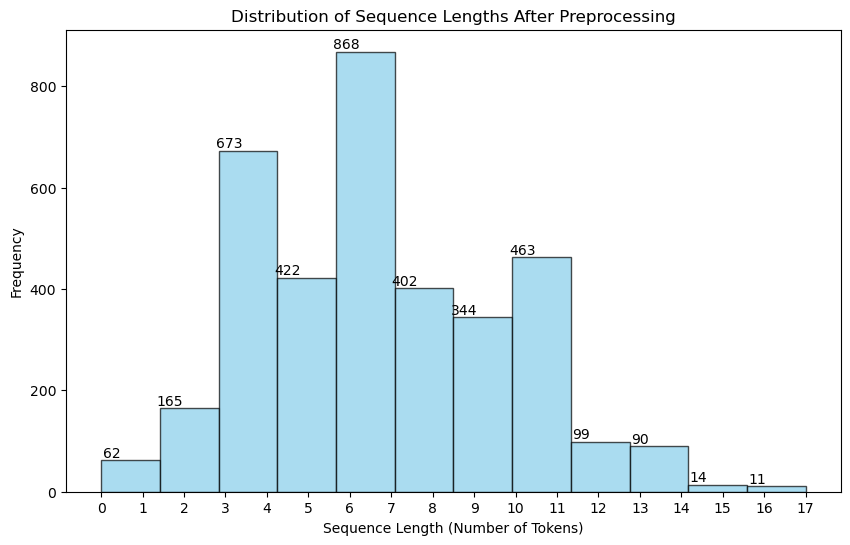

In [48]:
# Plotting the histogram
plt.figure(figsize = (10, 6))

# Adding count values on top of each bar
counts, bins, patches = plt.hist(sequence_lengths, bins = num_bins, alpha = 0.7, color = 'skyblue', edgecolor = 'black')

# Looping through each bar and displaying the count on top of it
for count, bin_edge in zip(counts, bins):
    # Calculating the position of the count label
    if count > 0:  # Only adding labels to non-zero counts
        plt.text(bin_edge + 0.25, count, str(int(count)), ha = 'center', va = 'bottom', fontsize = 10, color = 'black')

# Setting x-axis to show every integer tick (instead of default ticks that was 2.5)
plt.xticks(np.arange(min(sequence_lengths), max(sequence_lengths) + 1, 1))
        
plt.title('Distribution of Sequence Lengths After Preprocessing')
plt.xlabel('Sequence Length (Number of Tokens)')
plt.ylabel('Frequency')
plt.show()

In [49]:
# Choosing a percentile value (95% in this case)
percentile = 95

# Calculating the sequence length at the chosen percentile
max_len = np.percentile(sequence_lengths, percentile)
max_len

12.0

In [50]:
# Choosing a percentile value (99% in this case)
percentile = 99

# Calculating the sequence length at the chosen percentile
max_len = np.percentile(sequence_lengths, percentile)
max_len

14.0

## <span style='color:blue'>Based on the histogram, most of the sequences fall between the 3rd and 8th bars, corresponding to lengths from 3 to around 12 tokens. This observation is consistent with the 95th percentile calculation, which also suggests a maximum length of 12. Since max_len directly affects the size of the input sequences after padding and truncating, and influences model performance, memory usage, and training efficiency, 12 tokens is a reasonable choice. However, looking further at the histogram, we notice that beyond the 10th bar, the frequency of sequences decreases significantly. This drop in frequency aligns with the 99th percentile, which suggests a slightly longer maximum sequence length. As a result, setting max_len to 14 tokens would be more appropriate, ensuring we capture almost all of the data while still keeping the sequence length manageable for model training.</span>

# 2. Modeling

## Choosing a vocabulary size and fitting a tokenizer on the preprocessed data

In [51]:
# Initializing vocabulary size
vocab_size = 10000

# Initializing the tokenizer
tokenizer = Tokenizer(num_words = vocab_size)

# Fitting a tokenizer on the preprocessed data
tokenizer.fit_on_texts(cleaned_train_text)

## Using tokenizer.text_to_sequences() to generate a list of index numbers for each tweet

In [52]:
train_sequences = tokenizer.texts_to_sequences(cleaned_train_text)
train_sequences

[[1802, 1803, 13, 192, 35, 48],
 [390, 437, 214, 35, 5],
 [244, 23, 49, 139, 438],
 [3617, 3618, 215, 1804, 3, 118, 2],
 [9, 348, 245, 3619, 2, 1, 3620, 16],
 [963, 1805, 668, 1806],
 [1807, 78, 2, 8, 3, 165, 586, 1808, 1809, 79, 16],
 [1810, 296, 83, 587, 1811, 2, 1812],
 [1802, 1803, 13, 192, 35],
 [3621, 793, 174, 349, 669],
 [8, 1813],
 [794, 8, 8],
 [151, 216, 1814, 217],
 [78, 7, 13, 3, 3622],
 [3623, 5, 84, 3624, 11, 1275, 48, 3625],
 [3626, 2, 16],
 [3627, 3628, 3629, 588, 113, 3630, 589, 218, 9],
 [71, 1815, 71, 1816, 106, 166],
 [1817, 439, 440, 1818, 1819, 246, 140, 6, 964],
 [3631, 3632, 85, 350, 118, 72, 351],
 [1820, 2, 1821, 504, 267, 43, 18, 48],
 [152, 219, 35, 297, 35, 48],
 [130, 352, 9, 8, 193, 10, 8, 1822, 1276],
 [391, 3, 36, 8, 8, 3633, 167, 215, 1823],
 [1824, 439, 220, 84, 321, 1825, 1826, 79],
 [1827, 8, 298, 348, 3, 2, 1277, 590],
 [1828, 118, 669],
 [78, 1278, 505, 78, 247],
 [1807, 78, 2, 8, 3, 165, 586, 1808, 1809],
 [965, 8, 1829, 3634, 1279, 441, 166, 8,

In [53]:
test_sequences = tokenizer.texts_to_sequences(cleaned_test_text)
val_sequences = tokenizer.texts_to_sequences(cleaned_val_text)

## Using padding/truncating to make each sequence the same length, as chosen before

In [54]:
X_train = pad_sequences(train_sequences, maxlen = int(max_len))
X_test = pad_sequences(test_sequences, maxlen = int(max_len))
X_val = pad_sequences(val_sequences, maxlen = int(max_len))
X_train.shape

(3613, 14)

## Creating and compiling a model using tf.keras.Sequential to predict the emotion label from the text. Starting with an embedding layer and building an architecture from dense, LSTM, GRU, bidirectional LSTM or GRU, and dropout layers. Compiling the model using a choice of optimizer, sparse_binary_crossentropy for the loss, and the metric set to accuracy

In [55]:
embedding_dim = 32 # Embedding dimension for the words
num_classes = 4 # Considering the 4 emotion labels we have (anger, fear, joy, sadness)

In [56]:
# Creating the model
initial_model = Sequential()

# Embedding layer
initial_model.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = int(max_len)))
initial_model.add(SpatialDropout1D(0.5)) # Adding a spatial dropout of 50%

# Bidirectional LSTM Layer (process sequences in both directions)
initial_model.add(Bidirectional(LSTM(64)))  # LSTM layer with 64 units
initial_model.add(Dropout(0.5))  # Dropout to prevent overfitting

# Dense Layer (fully connected layer to output predictions)
initial_model.add(Dense(32, activation = 'relu'))  # Dense layer with 32 units

# Output layer (four neurons for multi-class classification based on emotion labels we have)
initial_model.add(Dense(num_classes, activation = 'softmax'))

2024-11-25 11:30:16.556669: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 11:30:16.557456: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-11-25 11:30:17.084950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-25 11:30:17.085995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] 

In [57]:
# Compiling the model using Adam as optimizer and 'Sparse categorical crossentropy' for integer labels
initial_model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Printing model summary to verify architecture
initial_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 32)            320000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 14, 32)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 4)                 1

## Training the model on the training data without using a validation split. Calculating and recording the training accuracy

In [58]:
# Recording  the starting time of the training process
tick = time()

# Training the model on the train data without using validation split
initial_model_history = initial_model.fit(X_train, train_encoded_labels, epochs = 20, batch_size = 64, validation_split = 0.0)

# Recording training time
initial_model_train_time = time() - tick

# Getting training accuracy history
initial_model_train_accuracy = initial_model_history.history['accuracy']

print('\n\nTraining Time:', initial_model_train_time)

Epoch 1/20


2024-11-25 11:30:17.490583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-25 11:30:17.491360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-25 11:30:17.492022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

57/57 [==============================] - 4s 40ms/step - loss: 1.3762 - accuracy: 0.3169
Epoch 2/20
57/57 [==============================] - 2s 36ms/step - loss: 1.3545 - accuracy: 0.3274
Epoch 3/20
57/57 [==============================] - 2s 33ms/step - loss: 1.2165 - accuracy: 0.4669
Epoch 4/20
57/57 [==============================] - 2s 30ms/step - loss: 0.8010 - accuracy: 0.6892
Epoch 5/20
57/57 [==============================] - 1s 25ms/step - loss: 0.4941 - accuracy: 0.8325
Epoch 6/20
57/57 [==============================] - 2s 27ms/step - loss: 0.3564 - accuracy: 0.8846
Epoch 7/20
57/57 [==============================] - 2s 27ms/step - loss: 0.2762 - accuracy: 0.9117
Epoch 8/20
57/57 [==============================] - 2s 27ms/step - loss: 0.2440 - accuracy: 0.9267
Epoch 9/20
57/57 [==============================] - 2s 27ms/step - loss: 0.1901 - accuracy: 0.9410
Epoch 10/20
57/57 [==============================] - 2s 27ms/step - loss: 0.1626 - accuracy: 0.9510
Epoch 11/20
57/57 [=

In [59]:
# Printing the training accuracy per epoch
print('Initial Model Training Accuracy per Epoch: \n')
for epoch, acc in enumerate(initial_model_train_accuracy, start = 1):
    print(f'Epoch {epoch}: Training Accuracy = {acc:.4f}\n')

Initial Model Training Accuracy per Epoch: 

Epoch 1: Training Accuracy = 0.3169

Epoch 2: Training Accuracy = 0.3274

Epoch 3: Training Accuracy = 0.4669

Epoch 4: Training Accuracy = 0.6892

Epoch 5: Training Accuracy = 0.8325

Epoch 6: Training Accuracy = 0.8846

Epoch 7: Training Accuracy = 0.9117

Epoch 8: Training Accuracy = 0.9267

Epoch 9: Training Accuracy = 0.9410

Epoch 10: Training Accuracy = 0.9510

Epoch 11: Training Accuracy = 0.9524

Epoch 12: Training Accuracy = 0.9599

Epoch 13: Training Accuracy = 0.9637

Epoch 14: Training Accuracy = 0.9671

Epoch 15: Training Accuracy = 0.9654

Epoch 16: Training Accuracy = 0.9726

Epoch 17: Training Accuracy = 0.9698

Epoch 18: Training Accuracy = 0.9734

Epoch 19: Training Accuracy = 0.9743

Epoch 20: Training Accuracy = 0.9704



## Using the model to make predictions on the validation data. Calculating and recording the validation accuracy

In [60]:
# Making predictions on the validation data
initial_model_predictions = initial_model.predict(X_val)

# Converting predictions from probabilities to class labels
initial_model_predicted_labels = np.argmax(initial_model_predictions, axis = 1)

# Calculating validation accuracy
initial_model_validation_accuracy = accuracy_score(val_encoded_labels, initial_model_predicted_labels)

# Printing the validation accuracy
print(f'Initial Model Validation Accuracy: {initial_model_validation_accuracy:.4f}')

2024-11-25 11:30:50.977680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-25 11:30:50.978592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-25 11:30:50.979264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 1s 9ms/step
Initial Model Validation Accuracy: 0.8300


## Displaying the confusion matrix for the validation data

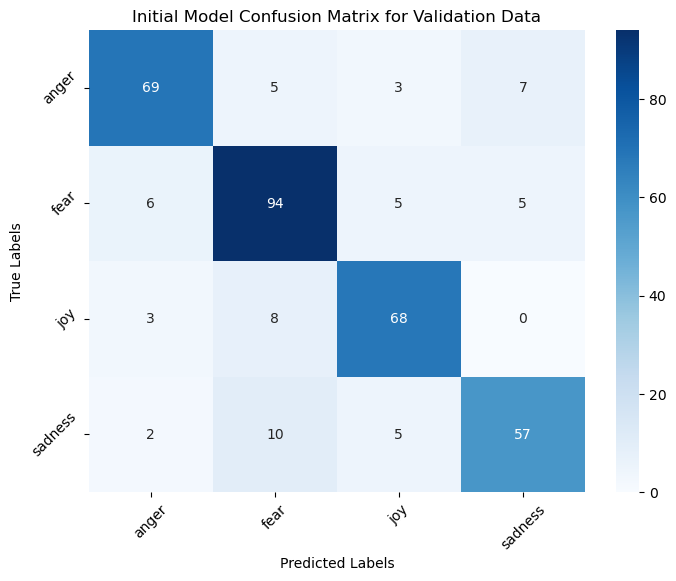

In [92]:
# Defining the emotion labels we have
emotion_labels = ['anger', 'fear', 'joy', 'sadness']

# Generating the confusion matrix
cm = confusion_matrix(val_encoded_labels, initial_model_predicted_labels)

# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = emotion_labels, yticklabels = emotion_labels)

# Customize the plot
plt.title("Initial Model Confusion Matrix for Validation Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## <span style='color:blue'>For anger we have:</span>
* 69 TP
* 219 TN
* 11 FP
* 15 FN

## <span style='color:blue'>For fear we have:</span>
* 94 TP
* 194 TN
* 23 FP
* 16 FN

## <span style='color:blue'>For joy we have:</span>
* 68 TP
* 220 TN
* 13 FP
* 11 FN

## <span style='color:blue'>For sadness we have:</span>
* 57 TP
* 231 TN
* 17 FP
* 12 FN

## <span style='color:blue'>Given that the model's training accuracy in the last epoch was 0.970385, while the validation accuracy was 0.829971, we can conclude that the model is overfitting. However, it still generalizes to unseen data to some extent, although not perfectly.</span>

## Revisiting the previous steps to make at least three models in total by changing architecture and hyperparameters

In [62]:
# Creating the model
model_1 = Sequential()

# Embedding layer
model_1.add(Embedding(input_dim = vocab_size, output_dim = embedding_dim, input_length = int(max_len)))
model_1.add(SpatialDropout1D(0.75)) # Adding a spatial dropout of 75%

# Bidirectional LSTM Layer (process sequences in both directions)
model_1.add(Bidirectional(LSTM(32)))  # LSTM layer with 64 units
model_1.add(Dropout(0.75))  # Dropout to prevent overfitting

# Dense Layer (fully connected layer to output predictions)
model_1.add(Dense(24, activation = 'relu'))  # Dense layer with 24 units

# Output layer (four neurons for multi-class classification based on emotion labels we have)
model_1.add(Dense(num_classes, activation = 'softmax'))

2024-11-25 11:30:51.620430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-25 11:30:51.621354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-25 11:30:51.621963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [63]:
# Compiling the model using Adam as optimizer and 'Sparse categorical crossentropy' for integer labels
model_1.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Printing model summary to verify architecture
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 14, 32)            320000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 14, 32)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
 dense_3 (Dense)             (None, 4)                

In [64]:
# Recording  the starting time of the training process
tick = time()

# Training the model on the train data without using validation split
model_1_history = model_1.fit(X_train, train_encoded_labels, epochs = 20, batch_size = 64, validation_split = 0.0)

# Recording training time
model_1_train_time = time() - tick

# Getting training accuracy history
model_1_train_accuracy = model_1_history.history['accuracy']

print('\n\nTraining Time:', model_1_train_time)

Epoch 1/20


2024-11-25 11:30:51.879237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-25 11:30:51.880084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-25 11:30:51.881416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

57/57 [==============================] - 4s 37ms/step - loss: 1.3794 - accuracy: 0.3028
Epoch 2/20
57/57 [==============================] - 2s 30ms/step - loss: 1.3700 - accuracy: 0.3224
Epoch 3/20
57/57 [==============================] - 2s 30ms/step - loss: 1.3514 - accuracy: 0.3429
Epoch 4/20
57/57 [==============================] - 1s 26ms/step - loss: 1.2918 - accuracy: 0.3961
Epoch 5/20
57/57 [==============================] - 2s 27ms/step - loss: 1.1717 - accuracy: 0.4877
Epoch 6/20
57/57 [==============================] - 2s 27ms/step - loss: 1.0133 - accuracy: 0.5796
Epoch 7/20
57/57 [==============================] - 2s 27ms/step - loss: 0.8678 - accuracy: 0.6374
Epoch 8/20
57/57 [==============================] - 2s 28ms/step - loss: 0.7667 - accuracy: 0.6823
Epoch 9/20
57/57 [==============================] - 2s 27ms/step - loss: 0.6867 - accuracy: 0.7241
Epoch 10/20
57/57 [==============================] - 1s 25ms/step - loss: 0.6159 - accuracy: 0.7487
Epoch 11/20
57/57 [=

In [65]:
# Printing the training accuracy per epoch
print('Model 1 Training Accuracy per Epoch: \n')
for epoch, acc in enumerate(model_1_train_accuracy, start = 1):
    print(f'Epoch {epoch}: Training Accuracy = {acc:.4f}\n')

Model 1 Training Accuracy per Epoch: 

Epoch 1: Training Accuracy = 0.3028

Epoch 2: Training Accuracy = 0.3224

Epoch 3: Training Accuracy = 0.3429

Epoch 4: Training Accuracy = 0.3961

Epoch 5: Training Accuracy = 0.4877

Epoch 6: Training Accuracy = 0.5796

Epoch 7: Training Accuracy = 0.6374

Epoch 8: Training Accuracy = 0.6823

Epoch 9: Training Accuracy = 0.7241

Epoch 10: Training Accuracy = 0.7487

Epoch 11: Training Accuracy = 0.7896

Epoch 12: Training Accuracy = 0.8107

Epoch 13: Training Accuracy = 0.8256

Epoch 14: Training Accuracy = 0.8494

Epoch 15: Training Accuracy = 0.8608

Epoch 16: Training Accuracy = 0.8757

Epoch 17: Training Accuracy = 0.8832

Epoch 18: Training Accuracy = 0.8921

Epoch 19: Training Accuracy = 0.9042

Epoch 20: Training Accuracy = 0.9134



In [66]:
# Making predictions on the validation data
model_1_predictions = initial_model.predict(X_val)

# Converting predictions from probabilities to class labels
model_1_predicted_labels = np.argmax(model_1_predictions, axis = 1)

# Calculating validation accuracy
model_1_validation_accuracy = accuracy_score(val_encoded_labels, model_1_predicted_labels)

# Printing the validation accuracy
print(f'Model 1 Validation Accuracy: {model_1_validation_accuracy:.4f}')

11/11 [==============================] - 0s 5ms/step
Model 1 Validation Accuracy: 0.8300


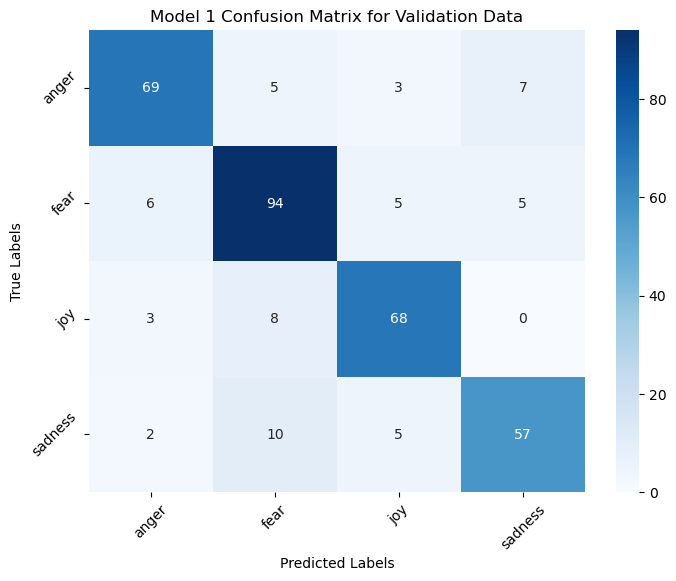

In [67]:
# Generating the confusion matrix
model_1_cm = confusion_matrix(val_encoded_labels, model_1_predicted_labels)

# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(model_1_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = emotion_labels, yticklabels = emotion_labels)

plt.title("Model 1 Confusion Matrix for Validation Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## <span style='color:blue'>For anger we have:</span>
* 69 TP
* 219 TN
* 11 FP
* 15 FN

## <span style='color:blue'>For fear we have:</span>
* 94 TP
* 194 TN
* 23 FP
* 16 FN

## <span style='color:blue'>For joy we have:</span>
* 68 TP
* 220 TN
* 13 FP
* 11 FN

## <span style='color:blue'>For sadness we have:</span>
* 57 TP
* 231 TN
* 17 FP
* 12 FN

## <span style='color:blue'>Given that the model's training accuracy in the last epoch was 0.913368, while the validation accuracy was 0.829971, we can conclude that the model is overfitting. However, it still generalizes to unseen data to some extent, although not perfectly. Compared to initial_model results model_1 is taking more time to identify the patterns within the training data (based on training accuracy differences).</span>

In [68]:
# Creating the model
model_2 = Sequential()

# Embedding layer
model_2.add(Embedding(input_dim = vocab_size, output_dim = 32, input_length = int(max_len)))
model_2.add(SpatialDropout1D(0.6)) # Adding a spatial dropout of 75%

# Bidirectional LSTM Layer (process sequences in both directions)
model_2.add(Bidirectional(LSTM(75)))  # LSTM layer with 64 units
model_2.add(Dropout(0.6))  # Dropout to prevent overfitting

# Dense Layer (fully connected layer to output predictions)
model_2.add(Dense(45, activation = 'relu'))  # Dense layer with 32 units

# Output layer (four neurons for multi-class classification based on emotion labels we have)
model_2.add(Dense(num_classes, activation = 'softmax'))

2024-11-25 11:31:24.667977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-25 11:31:24.668905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-25 11:31:24.669497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [69]:
# Compiling the model using Adam as optimizer and 'Sparse categorical crossentropy' for integer labels
model_2.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Printing model summary to verify architecture
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 14, 32)            320000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 14, 32)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_2 (Bidirectio  (None, 150)              64800     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_4 (Dense)             (None, 45)                6795      
                                                                 
 dense_5 (Dense)             (None, 4)                

In [70]:
# Recording  the starting time of the training process
tick = time()

# Training the model on the train data without using validation split
model_2_history = model_2.fit(X_train, train_encoded_labels, epochs = 20, batch_size = 64, validation_split = 0.0)

# Recording training time
model_2_train_time = time() - tick

# Getting training accuracy history
model_2_train_accuracy = model_2_history.history['accuracy']

print('\n\nTraining Time:', model_2_train_time)

Epoch 1/20


2024-11-25 11:31:24.954976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-25 11:31:24.955987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-25 11:31:24.956612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

57/57 [==============================] - 4s 43ms/step - loss: 1.3753 - accuracy: 0.3136
Epoch 2/20
57/57 [==============================] - 2s 32ms/step - loss: 1.3503 - accuracy: 0.3255
Epoch 3/20
57/57 [==============================] - 2s 30ms/step - loss: 1.1646 - accuracy: 0.4747
Epoch 4/20
57/57 [==============================] - 2s 27ms/step - loss: 0.8301 - accuracy: 0.6723
Epoch 5/20
57/57 [==============================] - 2s 28ms/step - loss: 0.6370 - accuracy: 0.7415
Epoch 6/20
57/57 [==============================] - 2s 30ms/step - loss: 0.4915 - accuracy: 0.8270
Epoch 7/20
57/57 [==============================] - 2s 28ms/step - loss: 0.3641 - accuracy: 0.8746
Epoch 8/20
57/57 [==============================] - 1s 26ms/step - loss: 0.2794 - accuracy: 0.9076
Epoch 9/20
57/57 [==============================] - 1s 26ms/step - loss: 0.2280 - accuracy: 0.9172
Epoch 10/20
57/57 [==============================] - 2s 26ms/step - loss: 0.1989 - accuracy: 0.9325
Epoch 11/20
57/57 [=

In [71]:
# Printing the training accuracy per epoch
print('Model 2 Training Accuracy per Epoch: \n')
for epoch, acc in enumerate(model_2_train_accuracy, start = 1):
    print(f'Epoch {epoch}: Training Accuracy = {acc:.4f}\n')

Model 2 Training Accuracy per Epoch: 

Epoch 1: Training Accuracy = 0.3136

Epoch 2: Training Accuracy = 0.3255

Epoch 3: Training Accuracy = 0.4747

Epoch 4: Training Accuracy = 0.6723

Epoch 5: Training Accuracy = 0.7415

Epoch 6: Training Accuracy = 0.8270

Epoch 7: Training Accuracy = 0.8746

Epoch 8: Training Accuracy = 0.9076

Epoch 9: Training Accuracy = 0.9172

Epoch 10: Training Accuracy = 0.9325

Epoch 11: Training Accuracy = 0.9391

Epoch 12: Training Accuracy = 0.9424

Epoch 13: Training Accuracy = 0.9552

Epoch 14: Training Accuracy = 0.9563

Epoch 15: Training Accuracy = 0.9552

Epoch 16: Training Accuracy = 0.9621

Epoch 17: Training Accuracy = 0.9640

Epoch 18: Training Accuracy = 0.9690

Epoch 19: Training Accuracy = 0.9660

Epoch 20: Training Accuracy = 0.9707



In [72]:
# Making predictions on the validation data
model_2_predictions = model_2.predict(X_val)

# Converting predictions from probabilities to class labels
model_2_predicted_labels = np.argmax(model_2_predictions, axis = 1)

# Calculating validation accuracy
model_2_validation_accuracy = accuracy_score(val_encoded_labels, model_2_predicted_labels)

# Printing the validation accuracy
print(f'Model 2 Validation Accuracy: {model_2_validation_accuracy:.4f}')

2024-11-25 11:31:59.031403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-11-25 11:31:59.032320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-11-25 11:31:59.032818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/11 [==========================>...] - ETA: 0s

2024-11-25 11:31:59.237515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-25 11:31:59.252576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 10ms/step
Model 2 Validation Accuracy: 0.8271


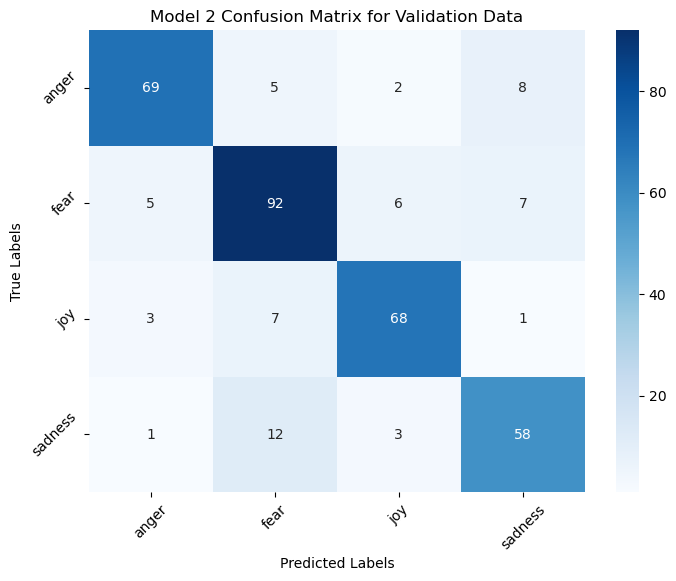

In [73]:
# Generating the confusion matrix
model_2_cm = confusion_matrix(val_encoded_labels, model_2_predicted_labels)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(model_2_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = emotion_labels, yticklabels = emotion_labels)

#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))

plt.title("Model 2 Confusion Matrix for Validation Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## <span style='color:blue'>For anger we have:</span>
* 69 TP
* 216 TN (decreased 3 units compared to initial_model and model_1)
* 9 FP (decreased 2 units compared to initial_model and model_1)
* 17 FN (increased 3 units compared to initial_model and model_1)

## <span style='color:blue'>For fear we have:</span>
* 92 TP (decreased 2 units compared to initial_model and model_1)
* 133 TN (decreased 61 units compared to initial_model and model_1)
* 24 FP (increased 1 unit compared to initial_model and model_1)
* 21 FN (increased 5 units compared to initial_model and model_1)

## <span style='color:blue'>For joy we have:</span>
* 68 TP
* 219 TN (decreased 1 unit compared to initial_model and model_1)
* 11 FP (decreased 2 units compared to initial_model and model_1)
* 11 FN

## <span style='color:blue'>For sadness we have:</span>
* 58 TP (increased 1 unit compared to initial_model and model_1)
* 229 TN (decreased 2 units compared to initial_model and model_1)
* 16 FP (decreased 1 unit compared to initial_model and model_1)
* 16 FN (increased 4 units compared to initial_model and model_1)

## <span style='color:blue'>Given that the model's training accuracy in the last epoch was 0.9707, while the validation accuracy was 0.8271, we can conclude that the model is overfitting. However, it still generalizes to unseen data to some extent, although not perfectly. Compared to initial_model and model_1 results is identifying a bit more patterns within the training data (based on training accuracy differences) and exhibits a lower performance while generalizing to unseen data (its validation accuracy is the lowest recorded so far).</span>

In [74]:
# Creating the model
model_3 = Sequential()

# Embedding layer
model_3.add(Embedding(input_dim = vocab_size, output_dim = 32, input_length = int(max_len)))

# Bidirectional LSTM Layer (process sequences in both directions)
model_3.add(GRU(64, reset_after=False))  # GRU layer with 64 units
model_3.add(Dropout(0.6))  # Dropout to prevent overfitting

# Dense Layer (fully connected layer to output predictions)
#model_2.add(GlobalAveragePooling1D())  # Taking average of sequence length for better generalization
model_3.add(Dense(45, activation = 'relu'))  # Dense layer with 32 units

# Output layer (four neurons for multi-class classification based on emotion labels we have)
model_3.add(Dense(num_classes, activation = 'softmax'))

In [75]:
# Compiling the model using Adam as optimizer and 'Sparse categorical crossentropy' for integer labels
model_3.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Printing model summary to verify architecture
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 14, 32)            320000    
                                                                 
 gru (GRU)                   (None, 64)                18624     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 45)                2925      
                                                                 
 dense_7 (Dense)             (None, 4)                 184       
                                                                 
Total params: 341,733
Trainable params: 341,733
Non-trainable params: 0
_________________________________________________________________


In [76]:
# Recording  the starting time of the training process
tick = time()

# Training the model on the train data without using validation split
model_3_history = model_3.fit(X_train, train_encoded_labels, epochs = 20, batch_size = 64, validation_split = 0.0)

# Recording training time
model_3_train_time = time() - tick

# Getting training accuracy history
model_3_train_accuracy = model_3_history.history['accuracy']

print('\n\nTraining Time:', model_3_train_time)

Epoch 1/20


2024-11-25 11:32:00.249285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 18s 301ms/step - loss: 1.3680 - accuracy: 0.3230
Epoch 2/20
57/57 [==============================] - 17s 300ms/step - loss: 1.1867 - accuracy: 0.4857
Epoch 3/20
57/57 [==============================] - 17s 294ms/step - loss: 0.7515 - accuracy: 0.7470
Epoch 4/20
57/57 [==============================] - 17s 295ms/step - loss: 0.3980 - accuracy: 0.8898
Epoch 5/20
57/57 [==============================] - 17s 293ms/step - loss: 0.2240 - accuracy: 0.9383
Epoch 6/20
57/57 [==============================] - 17s 290ms/step - loss: 0.1589 - accuracy: 0.9538
Epoch 7/20
57/57 [==============================] - 16s 283ms/step - loss: 0.1225 - accuracy: 0.9624
Epoch 8/20
57/57 [==============================] - 17s 299ms/step - loss: 0.1001 - accuracy: 0.9665
Epoch 9/20
57/57 [==============================] - 17s 306ms/step - loss: 0.0903 - accuracy: 0.9687
Epoch 10/20
57/57 [==============================] - 16s 285ms/step - loss: 0.0843 - accuracy: 0.9745


In [77]:
# Printing the training accuracy per epoch
print('Model 3 Training Accuracy per Epoch: \n')
for epoch, acc in enumerate(model_3_train_accuracy, start = 1):
    print(f'Epoch {epoch}: Training Accuracy = {acc:.4f}\n')

Model 3 Training Accuracy per Epoch: 

Epoch 1: Training Accuracy = 0.3230

Epoch 2: Training Accuracy = 0.4857

Epoch 3: Training Accuracy = 0.7470

Epoch 4: Training Accuracy = 0.8898

Epoch 5: Training Accuracy = 0.9383

Epoch 6: Training Accuracy = 0.9538

Epoch 7: Training Accuracy = 0.9624

Epoch 8: Training Accuracy = 0.9665

Epoch 9: Training Accuracy = 0.9687

Epoch 10: Training Accuracy = 0.9745

Epoch 11: Training Accuracy = 0.9759

Epoch 12: Training Accuracy = 0.9759

Epoch 13: Training Accuracy = 0.9776

Epoch 14: Training Accuracy = 0.9776

Epoch 15: Training Accuracy = 0.9798

Epoch 16: Training Accuracy = 0.9790

Epoch 17: Training Accuracy = 0.9792

Epoch 18: Training Accuracy = 0.9803

Epoch 19: Training Accuracy = 0.9795

Epoch 20: Training Accuracy = 0.9779



In [78]:
# Making predictions on the validation data
model_3_predictions = model_2.predict(X_val)

# Converting predictions from probabilities to class labels
model_3_predicted_labels = np.argmax(model_3_predictions, axis = 1)

# Calculating validation accuracy
model_3_validation_accuracy = accuracy_score(val_encoded_labels, model_3_predicted_labels)

# Printing the validation accuracy
print(f'Model 3 Validation Accuracy: {model_3_validation_accuracy:.4f}')

11/11 [==============================] - 0s 5ms/step
Model 3 Validation Accuracy: 0.8271


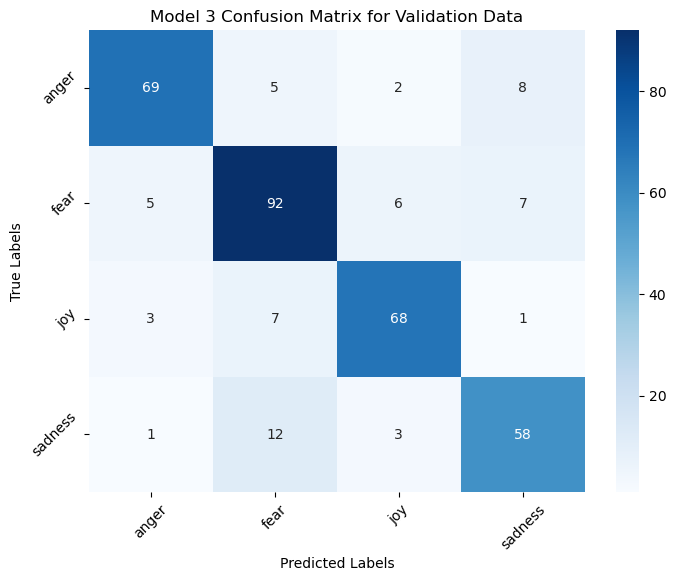

In [79]:
# Generating the confusion matrix
model_3_cm = confusion_matrix(val_encoded_labels, model_3_predicted_labels)

# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(model_3_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = emotion_labels, yticklabels = emotion_labels)

#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))

plt.title("Model 3 Confusion Matrix for Validation Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

## <span style='color:blue'>For anger we have:</span>
* 69 TP
* 218 TN (decreased 1 unit compared to model_1 and initial_model)
* 9 FP (decreased 2 units compared to initial_model and model_1)
* 17 FN (increased 2 units compared to initial_model and model_1)

## <span style='color:blue'>For fear we have:</span>
* 92 TP (decreased 2 units compared to initial_model and model_1)
* 195 TN (increased 1 unit compared to initial_model and model_1)
* 24 FP (increased 1 unit compared to initial_model and model_1)
* 18 FN (increased 2 units compared to initial_model and model_1)

## <span style='color:blue'>For joy we have:</span>
* 68 TP
* 219 TN (decreased 1 unit compared to initial_model and model_1)
* 11 FP (decreased 2 units compared to initial_model and model_1)
* 11 FN

## <span style='color:blue'>For sadness we have:</span>
* 58 TP (increased 1 unit compared to initial_model and model_1)
* 229 TN (decreased 2 units compared to initial_model and model_1)
* 15 FP (decreased 1 unit compared to initial_model and model_1)
* 16 FN (increased 4 units compared to initial_model and model_1)

## <span style='color:blue'>Given that the model's training accuracy in the last epoch was 0.9779 and the validation accuracy was 0.8271, we can conclude that the model is overfitting. However, it still generalizes to unseen data to some extent, although not perfectly. Compared to the results from the initial model, model_1, and model_2, this model took significantly longer to train. However, its training accuracy is the highest recorded training accuracy so far. In terms of generalization along with model_2, it shows a lower performance compared to initial_model and model_1.</span>

# 3. Discussion

## Commenting on the relative merits of each model. Selecting the best model based on quantitative metrics and plots and explaining this is the best model

In [91]:
model_names = ['initial_model', 'model_1', 'model_2', 'model_3']
training_acc = [initial_model_train_accuracy[-1], model_1_train_accuracy[-1], model_2_train_accuracy[-1], model_3_train_accuracy[-1]]
val_acc = [initial_model_validation_accuracy, model_1_validation_accuracy, model_2_validation_accuracy, model_3_validation_accuracy]
training_times = [initial_model_train_time, model_1_train_time, model_2_train_time, model_3_train_time]
notes = [
        'High training accuracy, overfitting, decent training time, generalizes to some extent',
        'The Lowest training accuracy, overfitting,  best training time, generalizes to some extent',
        'High training accuracy, overfitting, decent training time, lower generalization',
        'The Highest training accuracy, overfitting, excesive training time, lower generalization',
]

# Wraping long notes text
max_width = 50  # Adjusting the max width of the text to fit in the column
wrapped_notes = [textwrap.fill(note, max_width) for note in notes]

# Preparing the data for tabulation
model_comparison = zip(model_names, training_times, training_acc, val_acc, wrapped_notes)

# Creating the table using tabulate
table = tabulate(model_comparison, headers = ['Model', 'Training Times', 'Training Accuracy', 'Validation Accuracy', 'Notes'], 
                 tablefmt = 'fancy_grid', showindex = False, numalign = "center", stralign = "center")

# Printing the table
print(table)

╒═══════════════╤══════════════════╤═════════════════════╤═══════════════════════╤══════════════════════════════════════════════════╕
│     Model     │  Training Times  │  Training Accuracy  │  Validation Accuracy  │                      Notes                       │
╞═══════════════╪══════════════════╪═════════════════════╪═══════════════════════╪══════════════════════════════════════════════════╡
│ initial_model │     33.5601      │      0.970385       │       0.829971        │   High training accuracy, overfitting, decent    │
│               │                  │                     │                       │    training time, generalizes to some extent     │
├───────────────┼──────────────────┼─────────────────────┼───────────────────────┼──────────────────────────────────────────────────┤
│    model_1    │     32.4839      │      0.913368       │       0.829971        │ The Lowest training accuracy, overfitting,  best │
│               │                  │                     │    

## <span style='color:blue'>Based on what was stated before the best model is initial_model.</span>

In [88]:
best_model = initial_model

## Making predictions on the testing data, calculating the testing accuracy and displaying the confusion matrix for test data

In [89]:
# Making predictions on the testing data
best_model_predictions = best_model.predict(X_test)

# Converting predictions from probabilities to class labels
best_model_predicted_labels = np.argmax(best_model_predictions, axis = 1)

# Calculating validation accuracy
best_model_test_accuracy = accuracy_score(test_encoded_labels, best_model_predicted_labels)

# Printing the validation accuracy
print(f'Best Model Testing Accuracy: {best_model_test_accuracy:.4f}')

99/99 [==============================] - 1s 12ms/step
Best Model Testing Accuracy: 0.8205


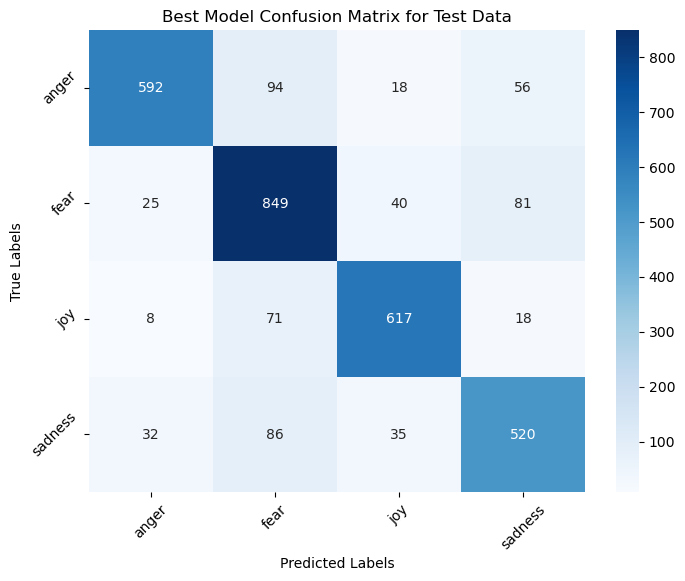

In [90]:
# Generating the confusion matrix
best_model_cm = confusion_matrix(test_encoded_labels, best_model_predicted_labels)

# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize = (8, 6))
sns.heatmap(best_model_cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = emotion_labels, yticklabels = emotion_labels)

#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))

plt.title("Best Model Confusion Matrix for Test Data")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

## Describing how well the model will work to classify the emotional connotation of a tweet. Providing a quantitative measure of accuracy and describing an shortcomings of the model

## <span style='color:blue'>**Quantitative Performance Metrics:**</span>
* ## **Training Accuracy:** 97.04%
* ## **Validation Accuracy:** 83.00%
* ## **Test Accuracy:** 82.05%

## <span style='color:blue'>**Insights / shortcommings of the model, based on previous results:**</span>

## <span style='color:blue'>The model demonstrates high accuracy on the training data, which suggests that it has learned the patterns in the training set well. However, the gap between training accuracy and validation/test accuracy indicates overfitting. This suggests that the model might be memorizing patterns specific to the training data, rather than learning to generalize effectively to new, unseen data. In short, while the model is overfitting to some extent, it still generalizes reasonably well, but there is room for improvement.</span>

## <span style='color:blue'>The test accuracy of 82.05% provides an indication of how the model is likely to perform in real-world scenarios, where tweets may come from a diverse range of users with different writing styles. While the performance here is decent, there is still room for improvement. Notably, increasing the number of epochs has been shown to improve the accuracy. This could be an area to explore further, potentially leading to better results.</span>

## <span style='color:blue'>Considering the nature of tweets — which often contain slang, sarcasm, abbreviations, and even emojis — the model may struggle to fully grasp the context behind these expressions. Training a model capable of understanding such nuances would be highly challenging, requiring more computational resources, and would likely involve complex logical and contextual reasoning. A more realistic path forward may be to focus on practical improvements such as:</span>

* ## **Increasing the number of epochs** to give the model more training time.
* ## **Data augmentation**, particularly by increasing the diversity of tweet data, which could improve the model’s ability to generalize to different types of language.
* ## **Fine-tuning** the model to optimize performance.
* ## **Exploring more advanced language models** (e.g., transformers, BERT, etc.) that are better equipped to handle the complexities of natural language, including slang and sarcasm.